# Emulate Single Wavelength

GP emulation of 6S for a fixed wavelength.

**Author:** Brian Schubert &lt;<schubert.b@northeastern.edu>&gt;

**Date:** 22 August 2023


In [179]:
import datetime
import itertools
import math
from typing import Final

import alive_progress
import matplotlib.pyplot as plt
import numpy as np
import rtm_wrapper.parameters as rtm_param
import scipy.stats.qmc as sci_qmc
import sklearn.decomposition as sklearn_decomp
import sklearn.gaussian_process as sklearn_gp
import sklearn.pipeline
import sklearn.preprocessing as sklearn_pre
import xarray as xr
from rtm_wrapper.engines.sixs import PySixSEngine, pysixs_default_inputs
from rtm_wrapper.execution import ConcurrentExecutor
from rtm_wrapper.simulation import SweepSimulation


def unit2range(arr: np.ndarray, bot: float, top: float) -> np.ndarray:
    return arr * (top - bot) + bot

## Set wavelength and input parameter ranges

In [180]:
# Fixed wavelength to simulate.
WAVELENGTH: Final = 0.59  # micrometers

# Atmosphere parameter ranges to simulate.
OZONE_RANGE: Final = (0.25, 0.45)  # cm-atm
WATER_RANGE: Final = (1, 4)  # g/cm^2
AOT_RANGE: Final = (0.05, 0.5)  # 1
ZENITH_RANGE: Final = (10, 60)  # degrees

INPUT_RANGES: Final = {
    "atmosphere.ozone": OZONE_RANGE,
    "atmosphere.water": WATER_RANGE,
    "aerosol_profile.aot": AOT_RANGE,
    # "geometry.solar_zenith": ZENITH_RANGE,
}

# Model output to emulate.
target_output: Final = "total_transmission"

## Define base 6S inputs

In [181]:
base_inputs = pysixs_default_inputs().replace(
    atmosphere=rtm_param.AtmosphereWaterOzone(),
    aerosol_profile=rtm_param.AerosolAOTSingleLayer(profile="Maritime", height=100),
    wavelength__value=WAVELENGTH,
)


def param_rich_name(param_name: str) -> str:
    meta = base_inputs.get_metadata(param_name)
    return f"{meta.get('title', param_name)} (${meta.get('unit', '?')}$)"

# Run true 6S simulation

## Sample atmosphere input ranges

In [182]:
# Number of LHS samples to draw.
NUM_SAMPLES: Final = 100

# Draw LHS samples.
rng = np.random.default_rng(2023_08_25)
lhs_sampler = sci_qmc.LatinHypercube(d=len(INPUT_RANGES), seed=rng)
raw_samples = lhs_sampler.random(NUM_SAMPLES)

# Draw Poisson disk samples
# pd_sampler = sci_qmc.PoissonDisk(d=2, seed=rng, radius=0.18)
# raw_samples = pd_sampler.random(NUM_SAMPLES)
# assert len(raw_samples) == NUM_SAMPLES, "failed to draw enough samples - try decreasing radius"

# Rescale LHS samples to parameter ranges.
input_samples = {
    input_name: unit2range(raw_samples[:, sample_column], *input_range)
    for sample_column, (input_name, input_range) in enumerate(INPUT_RANGES.items())
}

# Rescale LHS samples to parameter ranges.
# ozone_samples = unit2range(raw_samples[:, 0], *OZONE_RANGE)
# water_samples = unit2range(raw_samples[:, 1], *WATER_RANGE)
# # aot_samples = unit2range(raw_samples[:, 1], *AOT_RANGE)
# target_alt_samples  =unit2range(raw_samples[:, 2], TARGET_ALT_RANGE)

## Plot atmosphere input samples

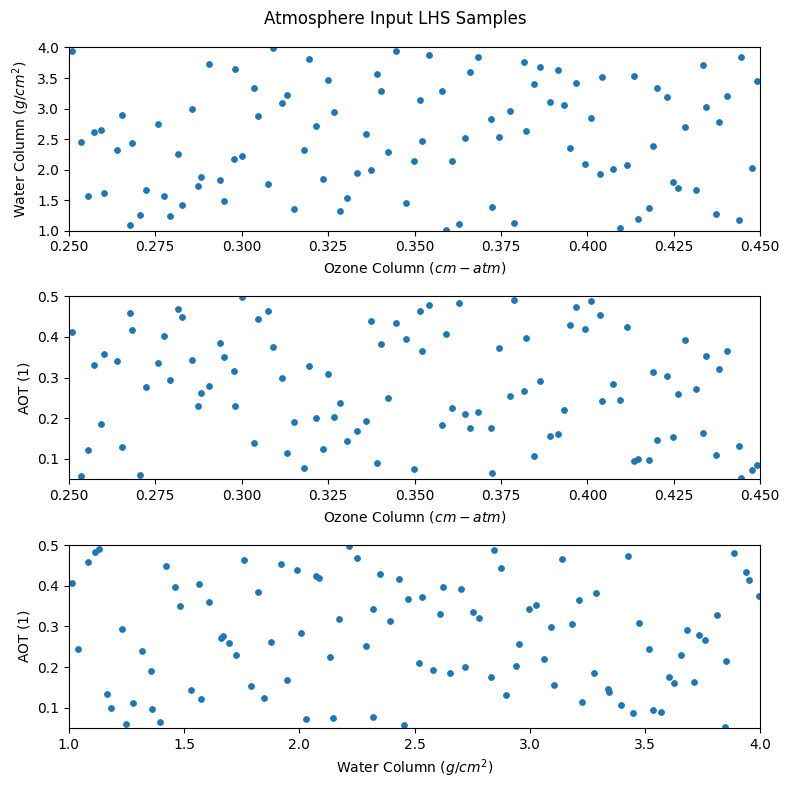

In [183]:
# fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(8,8))
# ax.scatter(ozone_samples, water_samples, aot_samples)

param_combos = list(itertools.combinations(INPUT_RANGES.keys(), r=2))
ncols = math.floor(math.sqrt(len(param_combos)))
nrows = math.ceil(len(param_combos) / ncols)

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8, 8))

for ax, (param_x, param_y) in zip(axs.flat, param_combos):
    ax.scatter(input_samples[param_x], input_samples[param_y], s=15)
    ax.set_xlim(INPUT_RANGES[param_x])
    ax.set_ylim(INPUT_RANGES[param_y])
    ax.set_xlabel(param_rich_name(param_x))
    ax.set_ylabel(param_rich_name(param_y))

fig.suptitle("Atmosphere Input LHS Samples")
fig.tight_layout()

## Perform simulation

In [184]:
sweep = SweepSimulation(
    {
        "lhs": input_samples,
    },
    base=base_inputs,
)

engine = PySixSEngine()
runner = ConcurrentExecutor(max_workers=16)

with alive_progress.alive_bar(sweep.sweep_size, force_tty=True) as bar:
    runner.run(sweep, engine, step_callback=lambda _: bar())

train_results = runner.collect_results()
train_output = train_results.data_vars[target_output]

display(train_results)

|████████████████████████████████████████| 100/100 [100%] in 4.8s (21.15/s)     


<xarray.Dataset>
Dimensions:                        (lhs: 100)
Coordinates:
  * lhs                            (lhs) int64 0 1 2 3 4 5 ... 94 95 96 97 98 99
    atmosphere.ozone               (lhs) float64 0.3077 0.3035 ... 0.4202 0.4114
    atmosphere.water               (lhs) float64 1.759 3.342 ... 3.338 2.074
    aerosol_profile.aot            (lhs) float64 0.4635 0.1394 ... 0.1462 0.4251
Data variables:
    transmittance_diffuse_up       (lhs) float64 0.4369 0.2041 ... 0.2099 0.4134
    transmittance_direct_down      (lhs) float64 0.5361 0.7805 ... 0.7744 0.5605
    transmittance_scattering_down  (lhs) float64 0.9055 0.9434 ... 0.9426 0.9101
    transmittance_total_gas        (lhs) float64 0.8964 0.8523 ... 0.8395 0.8748
    total_transmission             (lhs) float64 0.8117 0.8041 ... 0.7913 0.7961
    transmittance_diffuse_down     (lhs) float64 0.3694 0.1629 ... 0.1683 0.3496
    transmittance_scattering_up    (lhs) float64 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0
    transmittance_direct_up        (lhs) float64 0.5631 0.7959 ... 0.7901 0.5866
    apparent_radiance              (lhs) float64 117.5 114.3 ... 112.5 115.0
Attributes:
    version:     0.2.0.dev0+54b784e
    platform:    CPython 3.10.12 (Linux atricapillus 6.2.0-26-generic #26~22....
    engine:      rtm_wrapper.engines.sixs.PySixSEngine
    base_repr:   Inputs(altitude_target=AltitudePredefined(name='sealevel'), ...
    base_pzb64:  H4sIAEH57WQC/1VRy07rMBAFBCWIx70gHluWICE2fACKdHULahFvsbQmZJpY...
    sim_start:   2023-08-29T09:57:16.331373-04:00
    sim_end:     2023-08-29T09:57:21.132420-04:00

## Plot scatter of outputs at each input

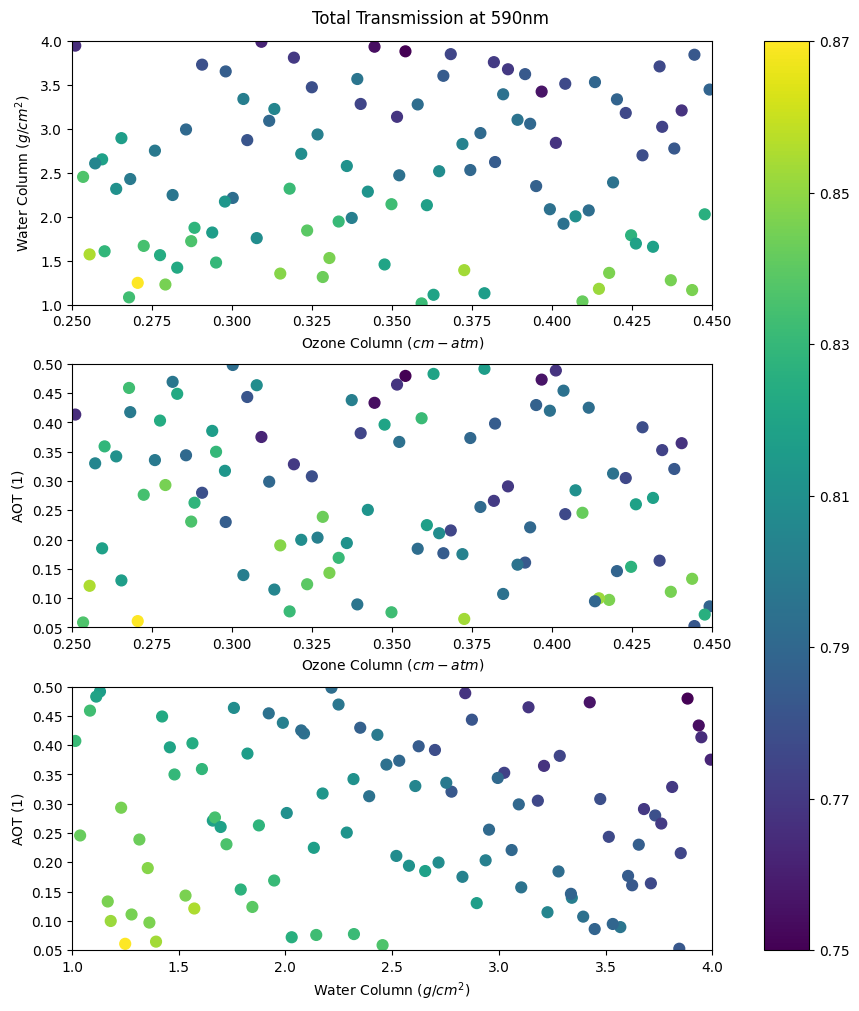

In [185]:
color_source = train_output.values
color = (color_source - color_source.min()) / (color_source.max() - color_source.min())

# fig, ax =  plt.subplots(subplot_kw={"projection": "3d"}, figsize=(8,8))
# art = ax.scatter(
#     train_results.coords["atmosphere.ozone"].values,
#     train_results.coords["atmosphere.water"].values,
#     train_results.coords["aerosol_profile.aot"].values,
#     c=color,
#     s=90,
#     cmap="viridis",
# )
param_combos = list(itertools.combinations(INPUT_RANGES.keys(), r=2))
ncols = math.floor(math.sqrt(len(param_combos)))
nrows = math.ceil(len(param_combos) / ncols)

fig, axs = plt.subplots(
    nrows=nrows, ncols=ncols, figsize=(8.5, 10), layout="constrained"
)

for ax, (param_x, param_y) in zip(axs.flat, param_combos):
    art = ax.scatter(input_samples[param_x], input_samples[param_y], c=color, s=60)
    ax.set_xlim(INPUT_RANGES[param_x])
    ax.set_ylim(INPUT_RANGES[param_y])
    ax.set_xlabel(param_rich_name(param_x))
    ax.set_ylabel(param_rich_name(param_y))

n_ticks = 7
cbar = fig.colorbar(art, ax=axs, ticks=np.linspace(0, 1, n_ticks))
cbar.ax.set_yticklabels(
    np.round(np.linspace(color_source.min(), color_source.max(), n_ticks), 2)
)
fig.suptitle(f"{train_output.attrs.get('title', 'Output')} at {WAVELENGTH*1000:.0f}nm");

# Train Emulator

## Extract training arrays

In [186]:
x_train = np.stack(
    [train_results.coords[parameter].values for parameter in INPUT_RANGES.keys()],
    axis=-1,
)
y_train = train_output.values.reshape(-1, 1)
print(f"{x_train.shape=}, {y_train.shape=}")

x_train.shape=(100, 3), y_train.shape=(100, 1)


## Create GP model

In [187]:
kernel = 1.0 * sklearn_gp.kernels.RBF()  # + sklearn_gp.kernels.WhiteKernel()
gaussian_process = sklearn_gp.GaussianProcessRegressor(
    kernel=kernel,
    n_restarts_optimizer=20,
    alpha=1e-2,
    # alpha=1,
    # Normalize targets to zero means, unit variance.
    normalize_y=True,
)

pipeline = sklearn.pipeline.Pipeline(
    [
        # Rescale input features to [0, 1].
        # ("scale", sklearn_pre.MinMaxScaler()),
        # Resacle to zero mean, unit variance
        ("normalize", sklearn_pre.StandardScaler(with_std=True)),
        ("pca", sklearn_decomp.PCA(n_components=len(INPUT_RANGES) - 1, whiten=True)),
        ("gp", gaussian_process),
    ]
)
display(pipeline)
display(pipeline.named_steps["gp"].kernel.hyperparameters)

Pipeline(steps=[('normalize', StandardScaler()),
                ('pca', PCA(n_components=2, whiten=True)),
                ('gp',
                 GaussianProcessRegressor(alpha=0.01,
                                          kernel=1**2 * RBF(length_scale=1),
                                          n_restarts_optimizer=20,
                                          normalize_y=True))])

[Hyperparameter(name='k1__constant_value', value_type='numeric', bounds=array([[1.e-05, 1.e+05]]), n_elements=1, fixed=False),
 Hyperparameter(name='k2__length_scale', value_type='numeric', bounds=array([[1.e-05, 1.e+05]]), n_elements=1, fixed=False)]

## Fit model

In [188]:
pipeline.fit(x_train, y_train)
display(pipeline.named_steps["gp"].kernel_)

3.19**2 * RBF(length_scale=5.06)

## Plot marginal likelihood surface

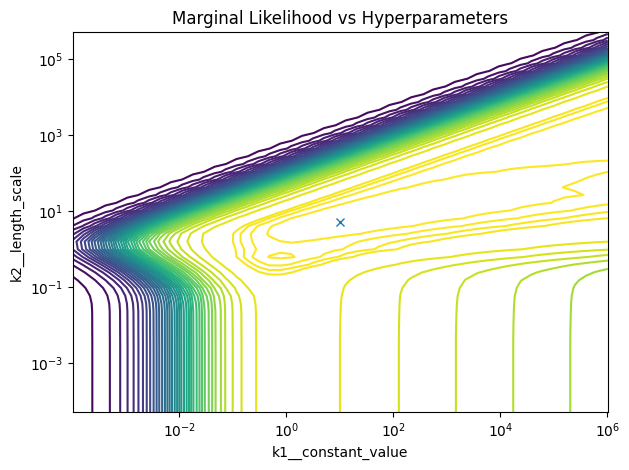

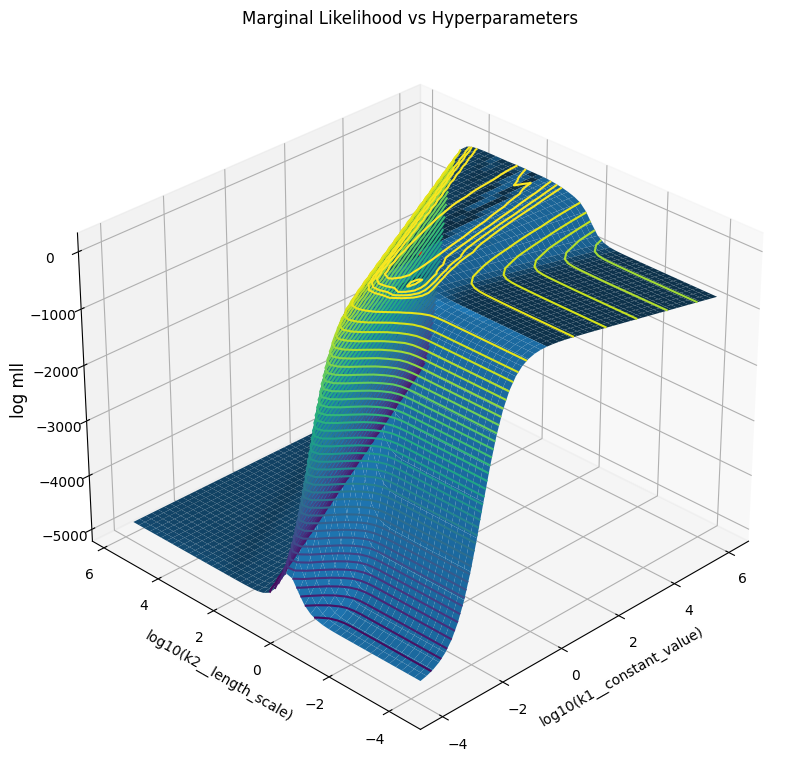

In [189]:
# Extract fit hyperparameter values.
fit_theta = pipeline.named_steps["gp"].kernel_.theta

# Indices of the two kernel hyperparameters to vary and plot MLL over.
plot_hyper_idx = [0, 1]
plot_hyper_names = [
    gaussian_process.kernel.hyperparameters[idx].name for idx in plot_hyper_idx
]

# Hyperparameter ranges to compute marginal likelihood over.
# Natural log scaled, and centered about fit hyperparameter values found above.
log_sweep_0 = np.log(10) * np.linspace(-5, 5, 50) + fit_theta[plot_hyper_idx[0]]
log_sweep_1 = np.log(10) * np.linspace(-5, 5, 50) + fit_theta[plot_hyper_idx[1]]


mesh_hyper_0, mesh_hyper_1 = np.meshgrid(log_sweep_0, log_sweep_1)
# Preallocate array for likelihood at each hyperparameter combination.
log_marginal_likelihoods = np.zeros(mesh_hyper_0.shape)

# Compute MLL for each hyperparameter combination.
for hyper_0, hyper_1, out in np.nditer(
    [mesh_hyper_0, mesh_hyper_1, log_marginal_likelihoods],
    op_flags=[["readonly"], ["readonly"], ["writeonly"]],
):
    theta = fit_theta.copy()
    theta[plot_hyper_idx[0]] = hyper_0
    theta[plot_hyper_idx[1]] = hyper_1
    out[...] = gaussian_process.log_marginal_likelihood(theta)

# Plot MLL contours.
fig, ax = plt.subplots()
ax.set_xscale("log")
ax.set_yscale("log")
# Pick contour levels. Increase level density near max to better show peaks.
peak_switch = np.percentile(log_marginal_likelihoods, 85)
levels = np.hstack(
    (
        np.linspace(log_marginal_likelihoods.min(), peak_switch, 40)[:-1],
        np.linspace(peak_switch, log_marginal_likelihoods.max(), 5),
    )
)
# levels = 30
art = ax.contour(
    np.exp(mesh_hyper_0), np.exp(mesh_hyper_1), log_marginal_likelihoods, levels
)
ax.plot(*np.exp(fit_theta), "x")
ax.set_xlabel(plot_hyper_names[0])
ax.set_ylabel(plot_hyper_names[1])
ax.set_title("Marginal Likelihood vs Hyperparameters")
fig.tight_layout()

# Plot 3D MLL surface.
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(8, 8))
ax.computed_zorder = False  # Prevent surface from hiding point, https://stackoverflow.com/q/51241367/11082165
ax.view_init(elev=30, azim=-135)
zlims = ax.get_zlim()
ax.scatter(
    [fit_theta[0] / np.log(10)],
    [fit_theta[1] / np.log(10)],
    [gaussian_process.log_marginal_likelihood(fit_theta)],
    c="r",
    s=5,
    zorder=2,
)
ax.plot_surface(
    mesh_hyper_0 / np.log(10),
    mesh_hyper_1 / np.log(10),
    log_marginal_likelihoods,
    # cmap="coolwarm",
    zorder=1,
)
ax.contour(
    mesh_hyper_0 / np.log(10),
    mesh_hyper_1 / np.log(10),
    log_marginal_likelihoods,
    levels=levels,
    zorder=3,
)

ax.set_xlabel(f"log10({plot_hyper_names[0]})")
ax.set_ylabel(f"log10({plot_hyper_names[1]})")
fig.supylabel("log mll")
ax.set_title("Marginal Likelihood vs Hyperparameters")
fig.tight_layout()

## Analyze PCs

In [190]:
display(pipeline.named_steps["pca"].singular_values_)
display(pipeline.named_steps["pca"].explained_variance_ratio_)

array([11.02883954,  9.78024478])

array([0.40545101, 0.31884396])

In [191]:
print(INPUT_RANGES.keys())
display(pipeline.named_steps["pca"].components_.T)

dict_keys(['atmosphere.ozone', 'atmosphere.water', 'aerosol_profile.aot'])


array([[ 0.66434761, -0.0918463 ],
       [ 0.46529066,  0.82748942],
       [-0.5849332 ,  0.55391833]])

# Asses Emulator

## Generate test data

In [192]:
grid_size = 10

dense_input_test = {
    param_name: np.linspace(*param_range, grid_size)
    for param_name, param_range in INPUT_RANGES.items()
}

## Obtain actual sim results for test data

In [193]:
import pathlib

load_results_file_format = "test_{wl}_{size}_{inputs}_{timestamp}.nc"
timestamp = "2023-08-29T09:42"
# timestamp = datetime.datetime.now().isoformat(timespec='minutes')

load_results_path = pathlib.Path(
    load_results_file_format.format(
        wl=f"{WAVELENGTH*1000:0.1f}",
        size=grid_size,
        inputs=''.join(INPUT_RANGES.keys()),
        timestamp=timestamp,
    )
)
if not load_results_path.exists():
    sweep = SweepSimulation(
        dense_input_test,
        base=base_inputs,
    )

    engine = PySixSEngine()
    runner = ConcurrentExecutor(max_workers=16)
    with alive_progress.alive_bar(sweep.sweep_size, force_tty=True) as bar:
        runner.run(sweep, engine, step_callback=lambda _: bar())

    test_results = runner.collect_results()
    test_results.to_netcdf(load_results_path)
    
else:
    test_results = xr.open_dataset(load_results_path)

test_output = test_results.data_vars[target_output]
display(test_output)

<xarray.DataArray 'total_transmission' (atmosphere.ozone: 10,
                                        atmosphere.water: 10,
                                        aerosol_profile.aot: 10)>
[1000 values with dtype=float64]
Coordinates:
  * atmosphere.ozone     (atmosphere.ozone) float64 0.25 0.2722 ... 0.4278 0.45
  * atmosphere.water     (atmosphere.water) float64 1.0 1.333 ... 3.667 4.0
  * aerosol_profile.aot  (aerosol_profile.aot) float64 0.05 0.1 ... 0.45 0.5
Attributes:
    title:    Total Transmission
    unit:     1

## Extract test arrays

In [194]:
dense_input_meshes = np.meshgrid(
    *dense_input_test.values(),
    indexing="ij",
)

x_test = np.hstack([mesh.reshape(-1, 1) for mesh in dense_input_meshes])
y_test = test_output.values.reshape(-1, 1)

# x_test[:, 0] = 0.3  # verify axes match by making ozone constant

print(f"{x_test.shape=}, {y_test.shape=}")

x_test.shape=(1000, 3), y_test.shape=(1000, 1)


## Evaluate model on test data

In [195]:
pred_mean, pred_std = pipeline.predict(x_test, return_std=True)
pred_error = y_test - pred_mean.reshape(-1, 1)

pred_mean = pred_mean.reshape(dense_input_meshes[0].shape)
pred_std = pred_std.reshape(dense_input_meshes[0].shape)
pred_error = pred_error.reshape(dense_input_meshes[0].shape)
y_test_shaped = y_test.reshape(dense_input_meshes[0].shape)

## Compute metrics

In [196]:
rmse = np.sqrt(np.mean(pred_error**2))

abs_error = np.abs(pred_error)

print(f"RMSE: {rmse:0.4f}")
print(f"Avg abs err: {np.mean(abs_error):0.4f}")
print(f"Max abs err: {np.max(abs_error):0.2f}")
print(f"Avg rel err: {np.mean(abs_error/y_test_shaped):0.2%}")
print(f"Max rel err: {np.max(abs_error/y_test_shaped):0.2%}")

RMSE: 0.0057
Avg abs err: 0.0046
Max abs err: 0.02
Avg rel err: 0.57%
Max rel err: 2.04%


## Plot posterior mean, std, error

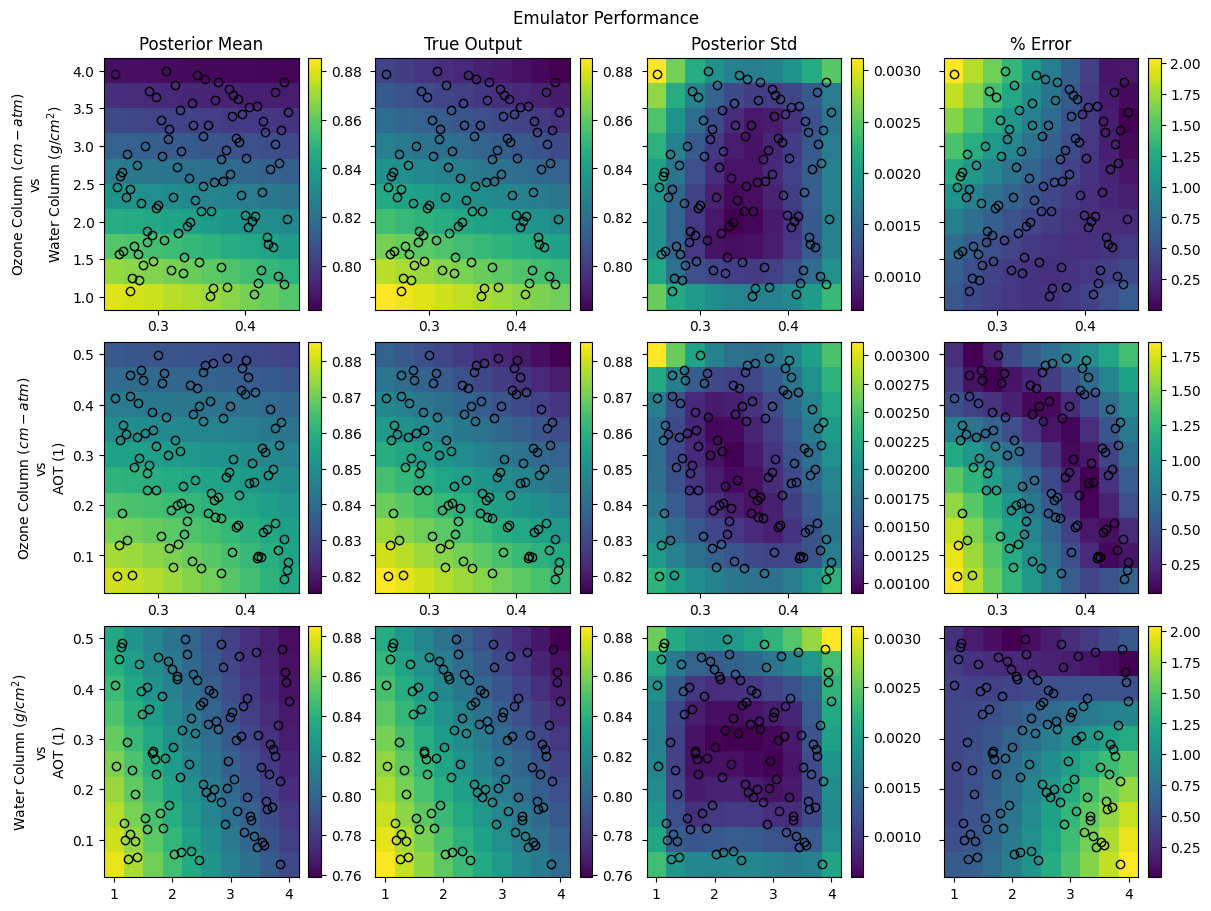

In [197]:
param_idx_combos = list(itertools.combinations(range(len(INPUT_RANGES)), r=2))
param_names = list(INPUT_RANGES.keys())
fig, axs = plt.subplots(
    nrows=len(param_idx_combos),
    ncols=4,
    figsize=(12, 3 * len(param_idx_combos)),
    sharex="row",
    sharey="row",
    layout="constrained",
)

for ax_row, (param_x_idx, param_y_idx) in zip(axs, param_idx_combos):
    local_mesh_x, local_mesh_y = np.meshgrid(
        dense_input_test[param_names[param_x_idx]],
        dense_input_test[param_names[param_y_idx]],
        indexing="ij",
    )

    other_dims = tuple(
        i for i in range(len(INPUT_RANGES)) if i not in (param_x_idx, param_y_idx)
    )

    pred_mean_only = pred_mean.max(axis=other_dims)
    y_test_only = y_test_shaped.max(axis=other_dims)
    pred_std_only = pred_std.max(axis=other_dims)
    pred_error_only = pred_error.max(axis=other_dims)

    vmin = min(pred_mean_only.min(), y_test_only.min())
    vmax = max(pred_mean_only.max(), y_test_only.max())

    # Plot predicted mean surface.
    ax = ax_row[0]
    art = ax.pcolormesh(
        local_mesh_x, local_mesh_y, pred_mean_only, vmin=vmin, vmax=vmax
    )
    ax.plot(
        input_samples[param_names[param_x_idx]],
        input_samples[param_names[param_y_idx]],
        "o",
        color="k",
        markerfacecolor="none",
    )

    cbar = fig.colorbar(art)

    # Plot true output surface.
    ax = ax_row[1]
    art = ax.pcolormesh(local_mesh_x, local_mesh_y, y_test_only, vmin=vmin, vmax=vmax)
    ax.plot(
        input_samples[param_names[param_x_idx]],
        input_samples[param_names[param_y_idx]],
        "o",
        color="k",
        markerfacecolor="none",
    )

    fig.colorbar(art)

    # Plot predicted variance surface.
    ax = ax_row[2]
    art = ax.pcolormesh(local_mesh_x, local_mesh_y, pred_std_only)
    ax.plot(
        input_samples[param_names[param_x_idx]],
        input_samples[param_names[param_y_idx]],
        "o",
        color="k",
        markerfacecolor="none",
    )

    fig.colorbar(art)

    # Plot error surface.
    ax = ax_row[3]
    art = ax.pcolormesh(
        local_mesh_x, local_mesh_y, 100 * np.abs(pred_error_only) / y_test_only
    )
    ax.plot(
        input_samples[param_names[param_x_idx]],
        input_samples[param_names[param_y_idx]],
        "o",
        color="k",
        markerfacecolor="none",
    )

    fig.colorbar(art)

    ax_row[0].set_ylabel(
        f"{param_rich_name(param_names[param_x_idx])}\nvs\n{param_rich_name(param_names[param_y_idx])}"
    )

axs[0, 0].set_title("Posterior Mean")
axs[0, 1].set_title("True Output")
axs[0, 2].set_title("Posterior Std")
axs[0, 3].set_title("% Error")
fig.suptitle("Emulator Performance");